# WGAN new model (training)


In [1]:
# !git clone https://github.com/medicinely/fwi.git
# %cd fwi

In [2]:
import os
import time
import numpy as np
import scipy as sc
import scipy.sparse as sp

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LightSource
from IPython.display import clear_output
from IPython import display
from progressbar import progressbar

import tensorflow as tf
from tensorflow.keras import layers
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import func.propagation as prop
import func.velmodel as vmod

device = 'gpu'
labelsize = 16

# from google.colab import drive
# drive.mount('/content/drive')

2024-01-09 15:15:23.675451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 15:15:24.032433: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-09 15:15:25.945511: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/yxie-l/anaconda3/envs/geostat/lib/
2024-01-09 15:15:25.945691: W tensorflow/comp

## Load Dataset

Overthrust shape:  (93, 401, 401)
(34980, 40, 120, 1)


2024-01-09 15:15:28.884068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-09 15:15:28.893318: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-09 15:15:28.893820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-09 15:15:28.902135: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

(34980, 40, 120, 1)


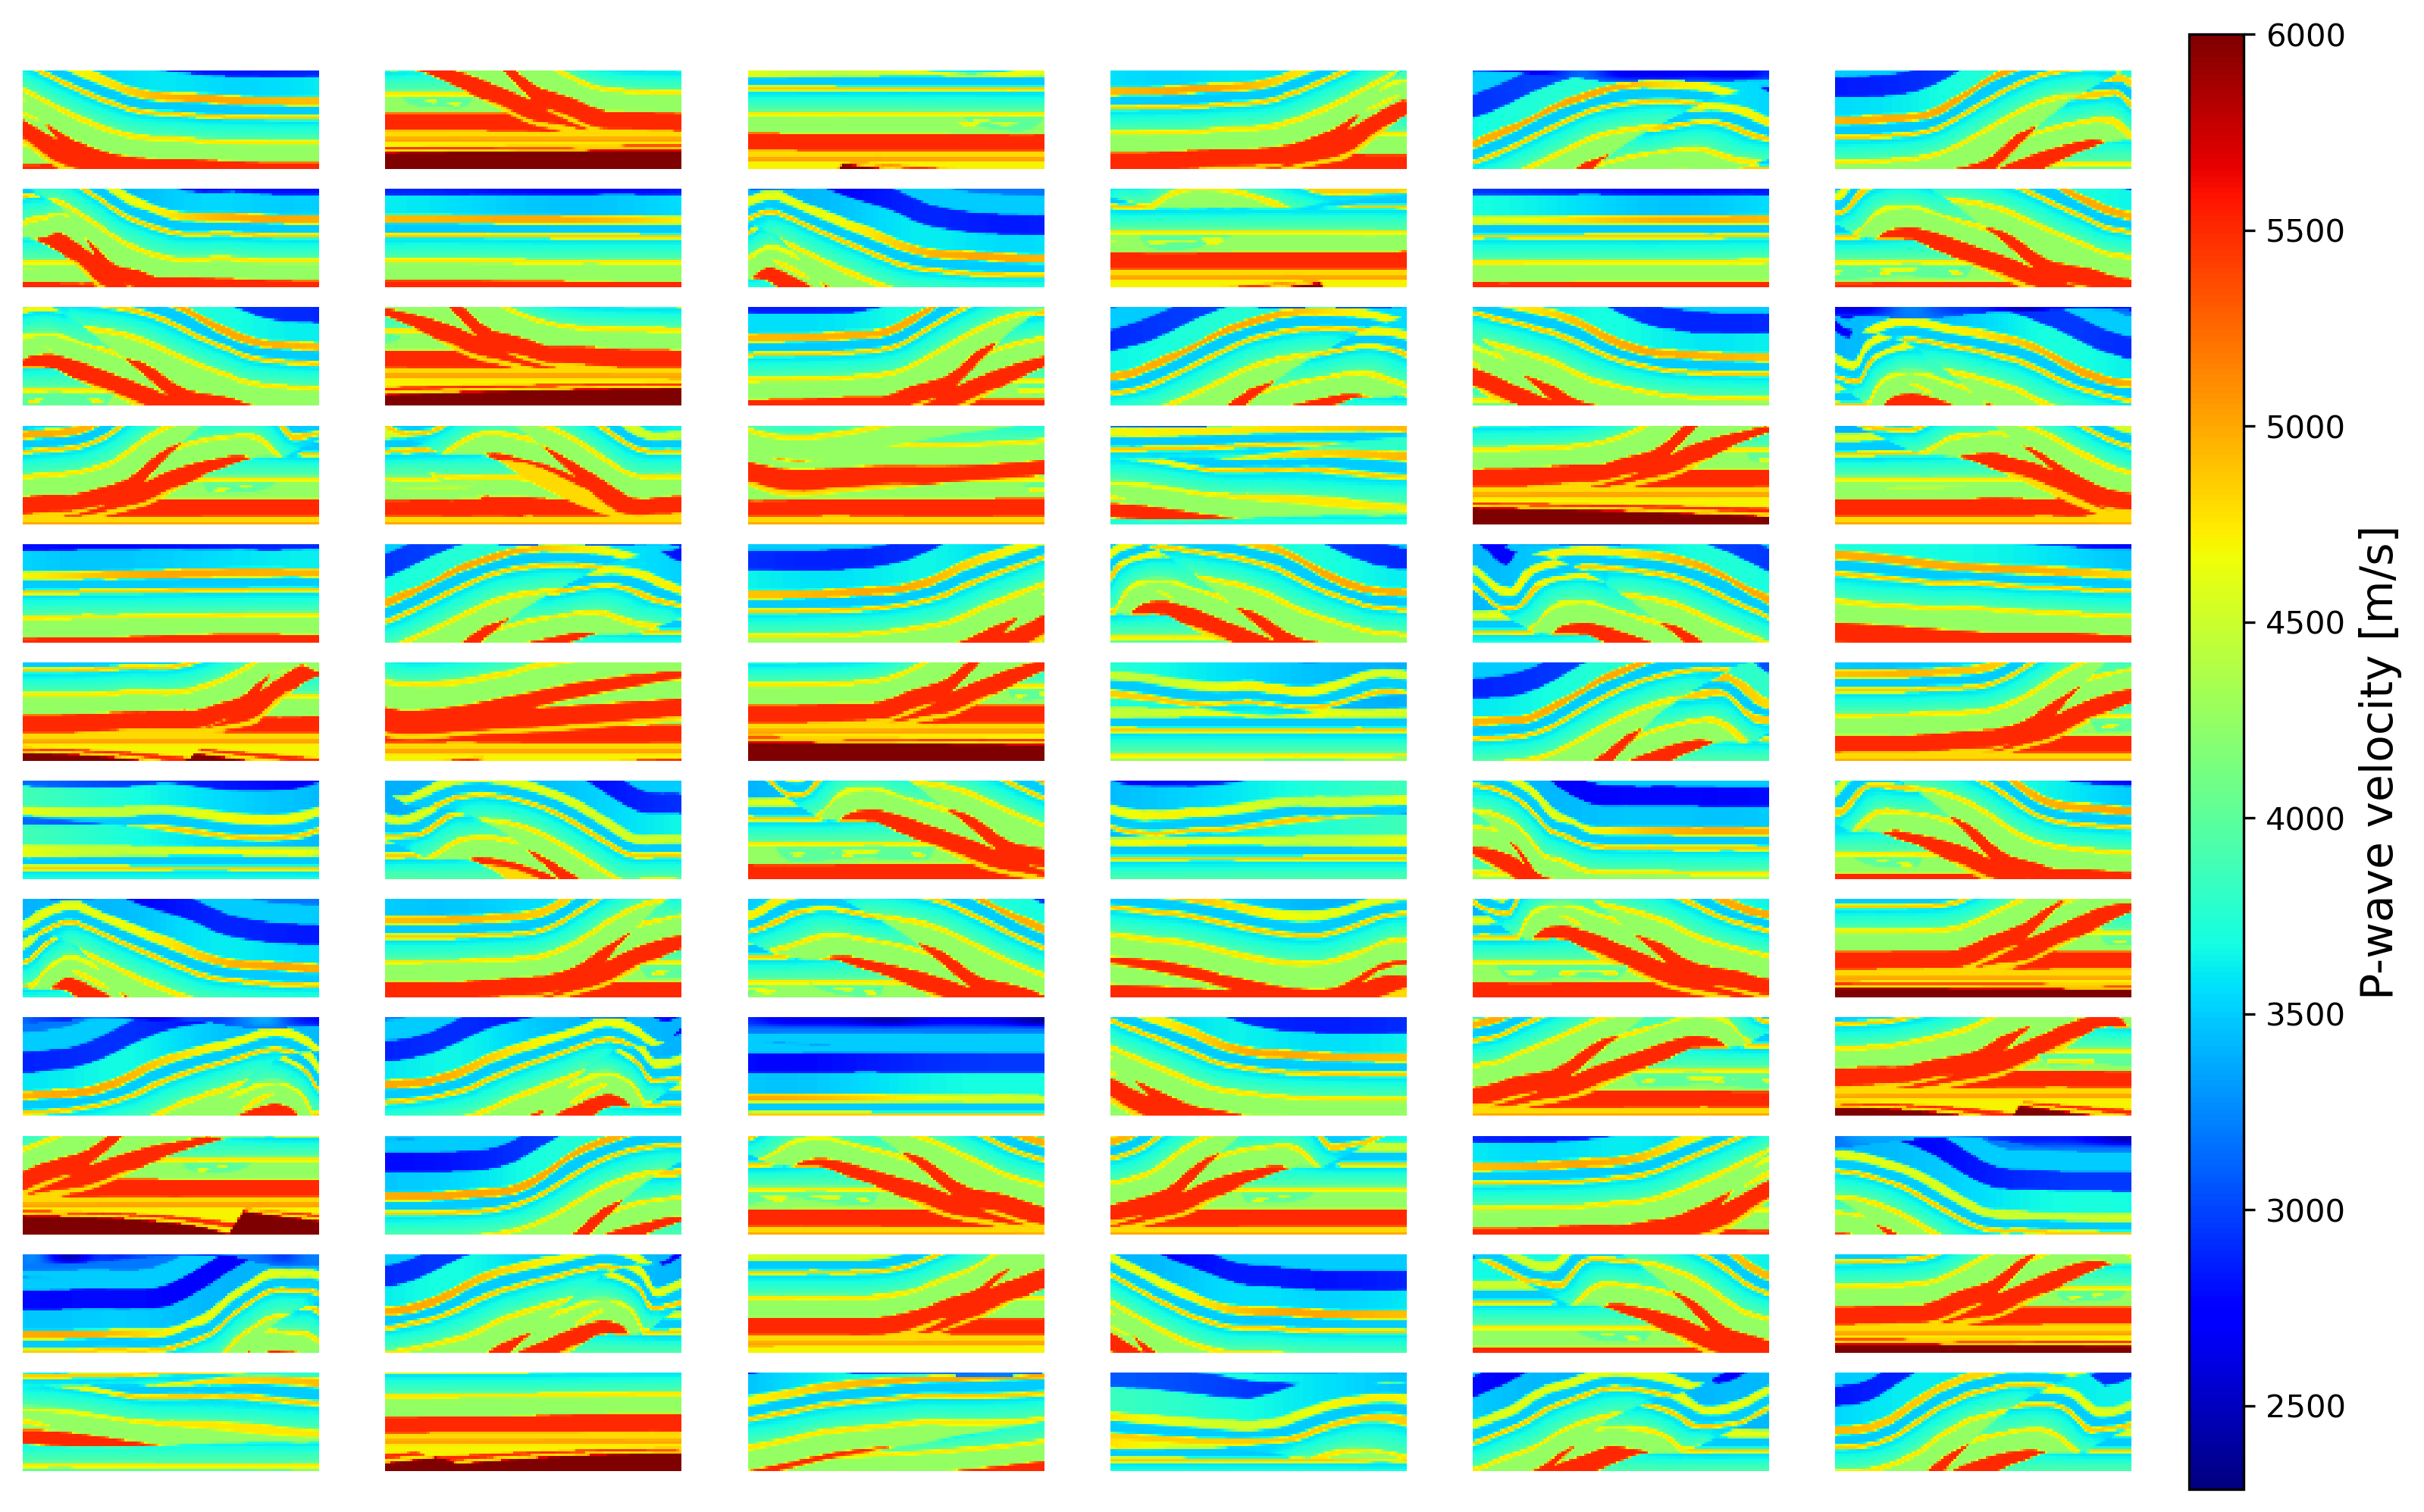

In [3]:
# n1=93 n2=401 n3=401 d1=d2=d3=50m
vel = vmod.readbin('../dataset/velocity/overthrust.bin',93,401*401)
# vel = vmod.readbin('/content/drive/MyDrive/yxieg/notebook/v.bin',93,401*401)
vel = np.reshape(vel,[93,401,401])
# vel = vel[::2,::2,::2]
print('Overthrust shape: ',vel.shape)
vel = vel[:81, 10:200, 10:200]
vmin, vmax = vel.min(), vel.max()

def crop_images(data, crop_size, z_interval, x_interval, y_interval):
    cropped_images = []
    nz, nx, ny = data.shape
    # Crop from direction 1
    for z in range(0, nz - crop_size[0], z_interval):
      for y in range(0, ny, y_interval):
          for x in range(0, nx - crop_size[1] + 1, x_interval):
              cropped_images.append(data[z:z+crop_size[0], x:x+crop_size[1], y])
    # Crop from direction 2
    for z in range(0, nz - crop_size[0], z_interval):
      for x in range(0, nx, x_interval):
          for y in range(0, ny - crop_size[1] + 1, y_interval):
              cropped_images.append(data[z:z+crop_size[0], x, y:y+crop_size[1]])
              # 45 degree direction
              cube = data[z:z+crop_size[0], x:x+crop_size[1], y:y+crop_size[1]]
              cube_diagonal = np.diagonal(cube, axis1=1, axis2=2)
              if cube_diagonal.shape==crop_size:
                cropped_images.append(cube_diagonal)
              cube_diagonal = np.diagonal(cube, axis1=2, axis2=1)
              if cube_diagonal.shape==crop_size:
                cropped_images.append(cube_diagonal)
    return np.array(cropped_images)


# Given data (replace this with your actual data)
crop_size = (40, 120)  # Crop size [height, width]
z_interval = 4  # Interval on z-axis
x_interval = 5 # Interval on x-axis
y_interval = 5  # Interval on y-axis

# Crop images
cropped_images = crop_images(vel, crop_size, z_interval, x_interval, y_interval)
n_img = cropped_images.shape[0]
cropped_images = cropped_images.reshape(n_img, crop_size[0], crop_size[1], 1).astype('float32')
# cropped_images = np.concatenate((cropped_images,np.flip(cropped_images,axis=1)), axis=0)
cropped_images = np.concatenate((cropped_images,np.flip(cropped_images,axis=2)), axis=0)
print(cropped_images.shape)
# cropped_images = cropped_images[:int(n_img - n_img%256),:,:,:]

# Upsample the images to the target size
# cropped_images = tf.image.resize(cropped_images, size=(200, 600))
cropped_images = tf.cast(cropped_images, tf.float32)
print(cropped_images.shape)

fig = plt.figure(figsize=(12, 8), dpi=300)
for i in range(72):
  plt.subplot(12, 6, i+1)
  plt.imshow(cropped_images[np.random.randint(cropped_images.shape[0]),:,:],cmap='jet',vmin=vmin,vmax=vmax)
  # plt.imshow(cropped_images[i,:,:],cmap='jet',vmin=vmin,vmax=vmax)
  plt.axis('off')
# Add a single colorbar for all subplots
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
cb = plt.colorbar(cax=cax)
cb.set_label("P-wave velocity [m/s]", fontsize=14)
# Show the plot
plt.show()

## Normalize images

In [4]:
train_images = cropped_images.numpy()
# train_images = train_images.reshape(train_images.shape[0], 201, 601, 1).astype('float32')
# train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
z1,x1 = train_images.shape[1],train_images.shape[2]
vmin, vmax = np.min(train_images),np.max(train_images)

def my_norm(a, min_val, max_val):
    ratio = 2/(max_val - min_val)
    shift = (max_val+min_val)/2
    return (a - shift)*ratio

def inverse_norm(a, min_val, max_val):
    ratio = 2 / (max_val - min_val)
    shift = (max_val + min_val) / 2
    return (a / ratio) + shift

train_images = my_norm(train_images,vmin,vmax)
print(train_images.min(),train_images.max())

BUFFER_SIZE = n_img
BATCH_SIZE = 256
dim_z = 100

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

-0.99999994 1.0000001


## Define Generator and Discriminator

In [9]:
kernal_size = (5, 5)
kernal_size_2 = (7, 7)

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(z1*x1//16*256, use_bias=False, input_shape=(dim_z,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((z1//4, x1//4, 256)))
    assert model.output_shape == (None, z1//4, x1//4, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # model.add(PixelShuffle(scale=2))  # Add Pixel Shuffle with scale 2

    model.add(layers.Conv2DTranspose(256, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernal_size, strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//2, x1//2, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, kernal_size, strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, z1, x1, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, kernal_size_2, strides=(2, 2), padding='same',
                                     input_shape=[z1, x1, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, kernal_size_2, strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, kernal_size, strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, kernal_size, strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, kernal_size, strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, kernal_size, strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# def discriminator_loss(real_output, fake_output):
#     real_loss = cross_entropy(tf.ones_like(real_output), real_output)
#     fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
#     total_loss = real_loss + fake_loss
#     return total_loss

# def generator_loss(fake_output):
#     return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

def gradient_penalty(batch_size, real_images, fake_images):
    """Calculates the gradient penalty.

    This loss is calculated on an interpolated image
    and added to the discriminator loss.
    """
    # Get the interpolated image
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        # 1. Get the discriminator output for this interpolated image.
        pred = discriminator(interpolated, training=True)

    # 2. Calculate the gradients w.r.t to this interpolated image.
    grads = gp_tape.gradient(pred, [interpolated])[0]
    # 3. Calculate the norm of the gradients.
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    # For each batch, we are going to perform the
    # following steps as laid out in the original paper:
    # 1. Train the generator and get the generator loss
    # 2. Train the discriminator and get the discriminator loss
    # 3. Calculate the gradient penalty
    # 4. Multiply this gradient penalty with a constant weight factor
    # 5. Add the gradient penalty to the discriminator loss
    # 6. Return the generator and discriminator losses as a loss dictionary
    extra_step = 5
    weight = 10.0

    # Train the discriminator first. The original paper recommends training
    # the discriminator for `x` more steps (typically 5) as compared to
    # one step of the generator. Here we will train it for 3 extra steps
    # as compared to 5 to reduce the training time.
    for i in range(extra_step):
      # Get the latent vector
      noise = tf.random.normal([BATCH_SIZE, dim_z])
      with tf.GradientTape() as tape:
        # Generate fake images from the latent vector
        fake_images = generator(noise, training=True)
        # Get the logits for the fake images
        fake_logits = discriminator(fake_images, training=True)
        # Get the logits for the real images
        real_logits = discriminator(images, training=True)

        # Calculate the discriminator loss using the fake and real image logits
        d_cost = discriminator_loss(real_img=real_logits, fake_img=fake_logits)
        # Calculate the gradient penalty
        gp = gradient_penalty(BATCH_SIZE, images, fake_images)
        # Add the gradient penalty to the original discriminator loss
        d_loss = d_cost + gp * weight

      # Get the gradients w.r.t the discriminator loss
      d_gradient = tape.gradient(d_loss, discriminator.trainable_variables)
      # Update the weights of the discriminator using the discriminator optimizer
      discriminator_optimizer.apply_gradients(
          zip(d_gradient, discriminator.trainable_variables)
      )

    # Train the generator
    # Get the latent vector
    noise = tf.random.normal([BATCH_SIZE, dim_z])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return [gen_loss, disc_loss]

def train(dataset, epochs):
  loss_history = []
  for epoch in range(epochs):
    start = time.time()

    for image_batch in progressbar(dataset):
      loss = train_step(image_batch)
    loss_history.append(loss)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed,
                             loss_history)

    # Save the model every n epochs
    if (epoch + 1) % 3 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed,
                           loss_history)
  return loss_history

def generate_and_save_images(model, epoch, test_input, loss_history):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  Gz = model(test_input, training=False)

  fig = plt.figure(figsize=(12, 8),dpi=300)
  plt.suptitle(f"Epoch {epoch}")
  for i in range(num_examples_to_generate):
    plt.subplot(10, 5, i+1)
    Gz_i = inverse_norm(Gz[i,:,:,0],vmin,vmax)
    plt.imshow(Gz_i,cmap='jet',vmin=vmin,vmax=vmax)
    plt.axis('off')

  # Add a single colorbar for all subplots
  cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
  cbar = plt.colorbar(cax=cax)
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=14)
  # Show the plot
  # plt.savefig('../dataset/checkpoint/wgan_gp_1/img/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


  fig = plt.figure(figsize=(8, 4),dpi=100)
  plt.plot(loss_history)
  plt.legend(['Generator loss', 'Discriminator loss'])
  plt.show()

## Display sample images

In [ ]:
seed = tf.random.normal([num_examples_to_generate, dim_z])
Gz = generator(seed, training=False)
fig = plt.figure(figsize=(12, 4),dpi=300)
plt.suptitle("Generated Samples")
for i in range(16):
  plt.subplot(4, 4, i+1)
  Gz_i = inverse_norm(Gz[i,:,:,0],vmin,vmax)
  plt.imshow(Gz_i,cmap='jet',vmin=vmin,vmax=vmax)
  plt.axis('off')
# Add a single colorbar for all subplots
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
cb = plt.colorbar(cax=cax)
cb.set_label("P-wave velocity [m/s]", fontsize=14)
plt.show()

## Train the model

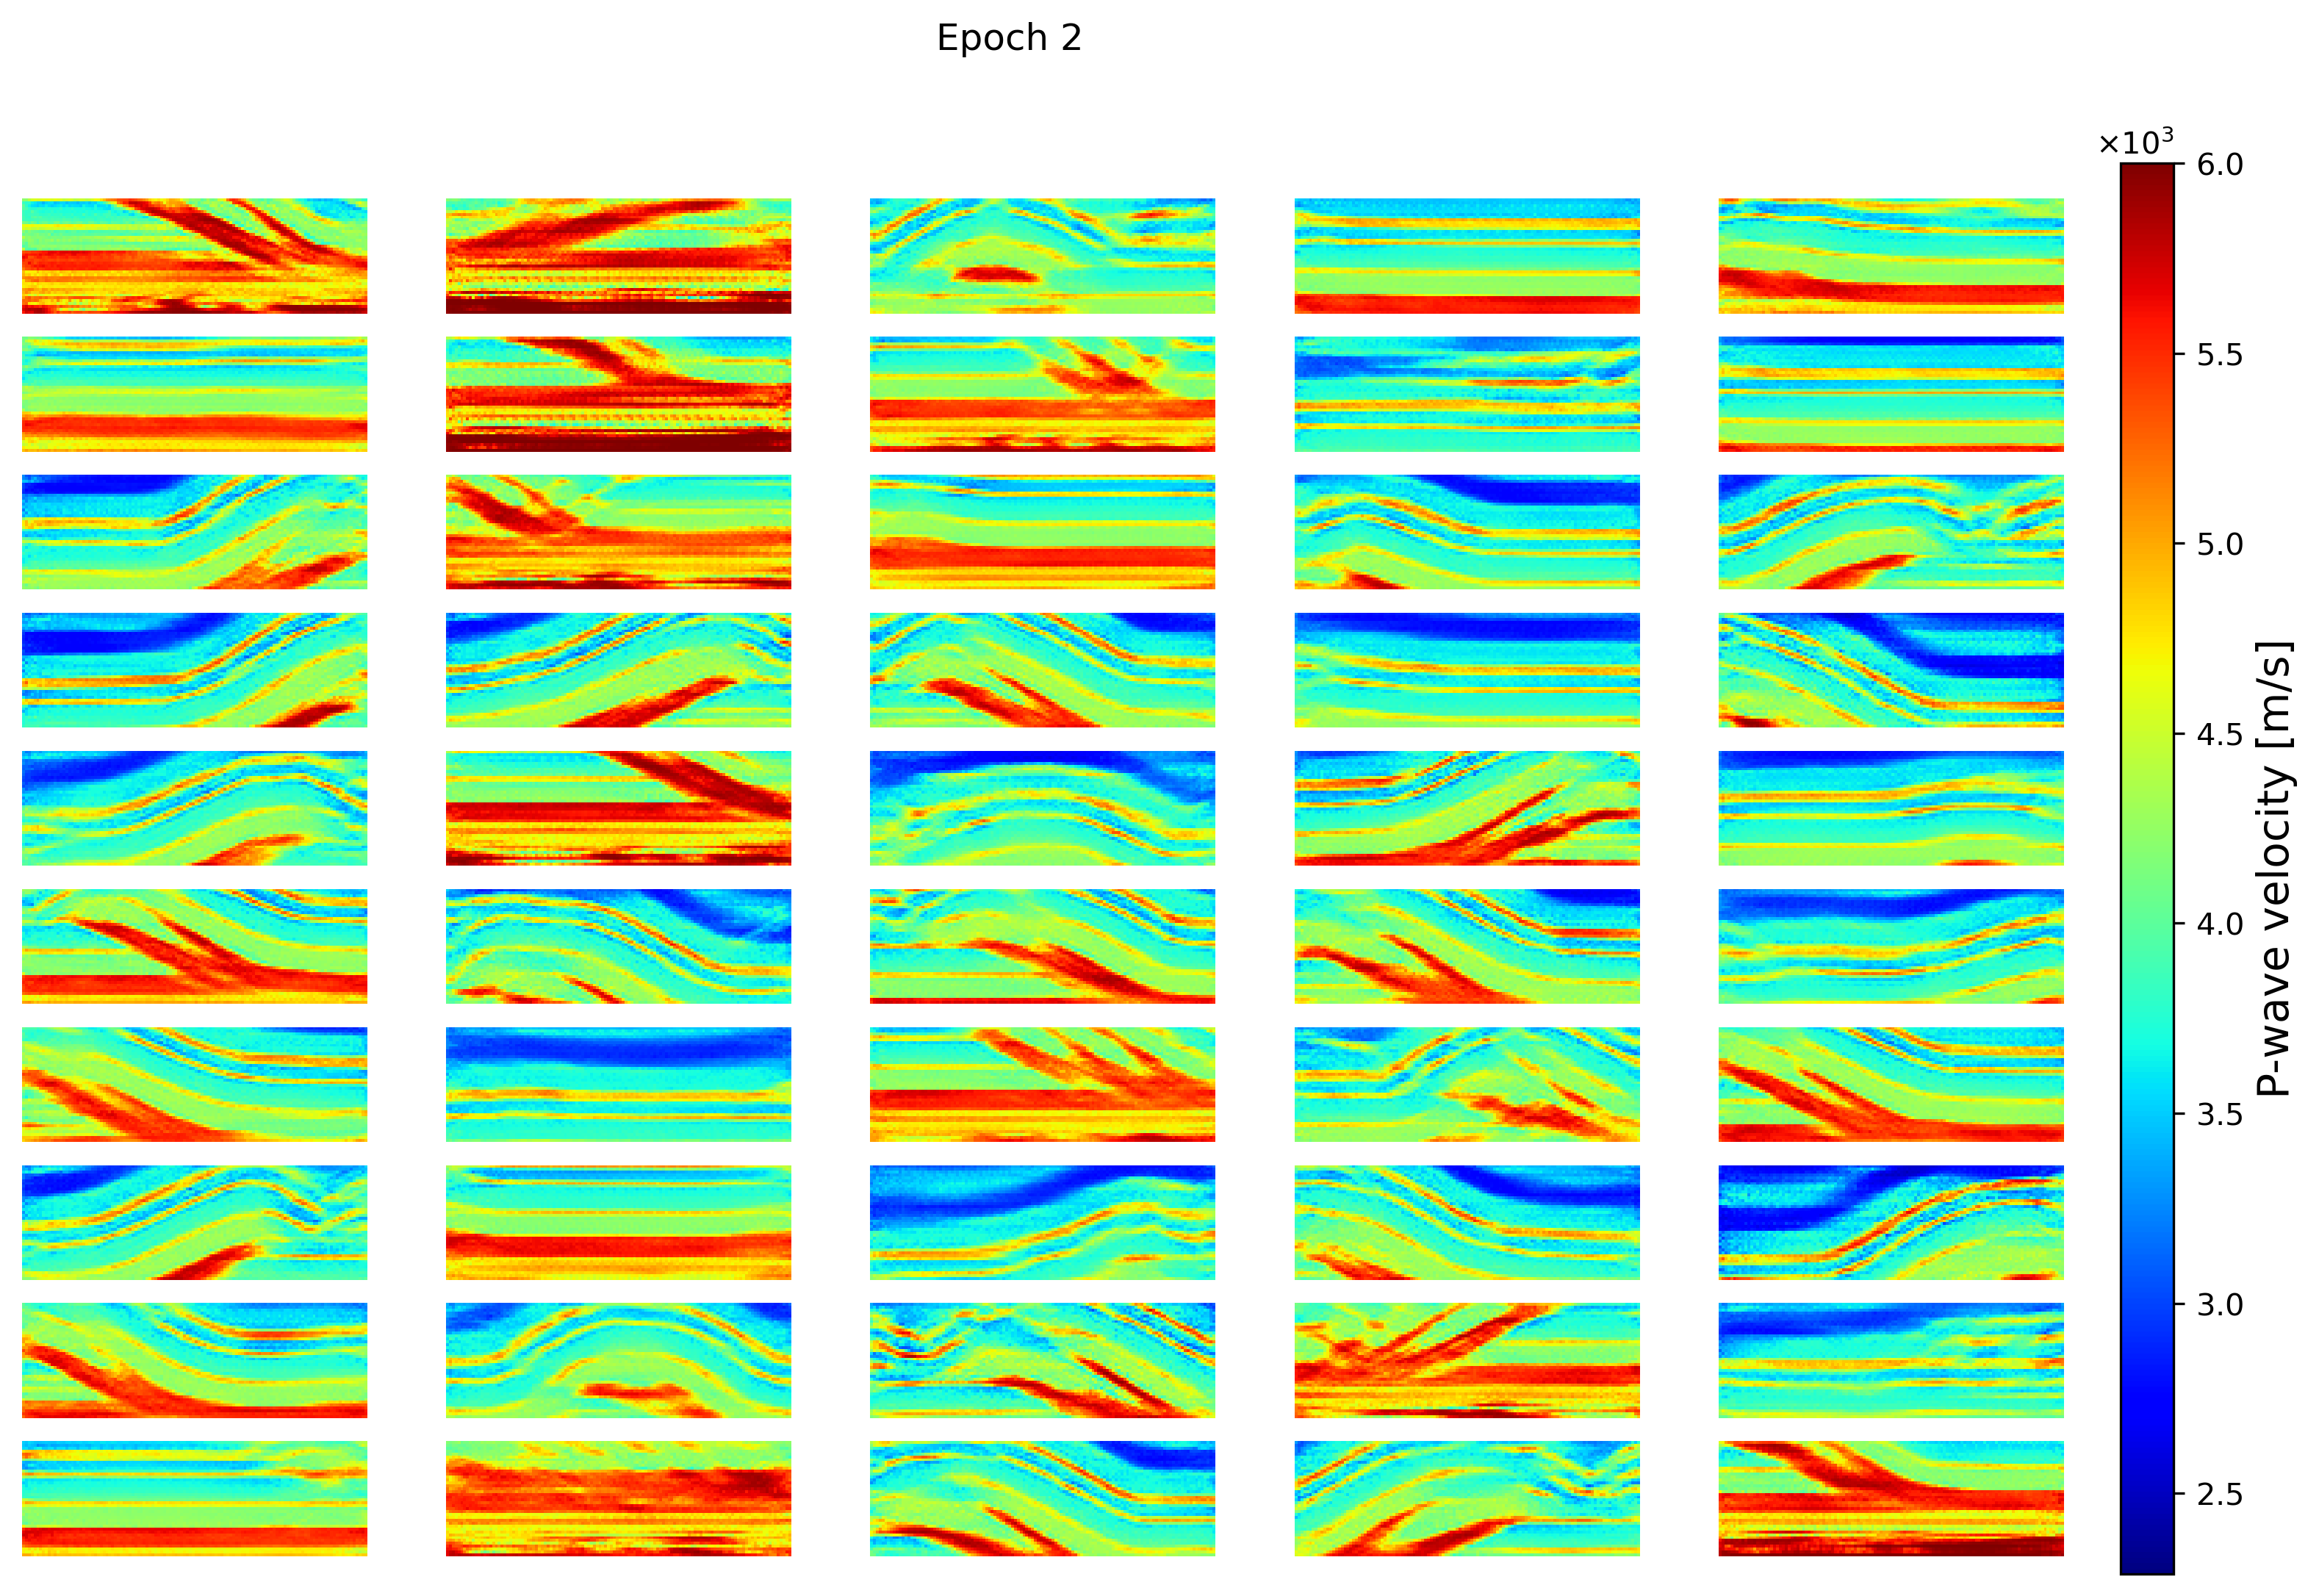

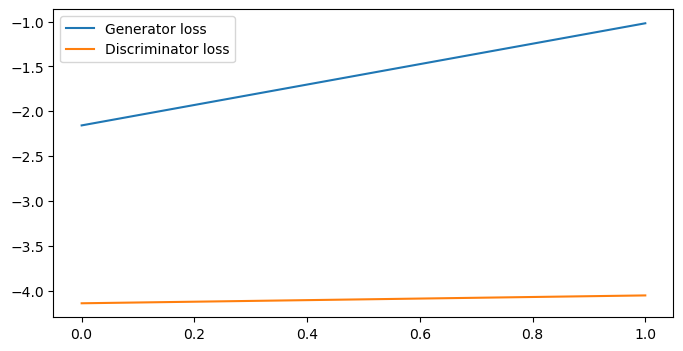

  0% (0 of 136) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Time for epoch 2 is 437.75765085220337 sec


  0% (1 of 136) |                        | Elapsed Time: 0:00:02 ETA:   0:05:48
  1% (2 of 136) |                        | Elapsed Time: 0:00:05 ETA:   0:06:57
  2% (3 of 136) |                        | Elapsed Time: 0:00:08 ETA:   0:06:57
  2% (4 of 136) |                        | Elapsed Time: 0:00:11 ETA:   0:06:53
  3% (5 of 136) |                        | Elapsed Time: 0:00:15 ETA:   0:06:49
  4% (6 of 136) |#                       | Elapsed Time: 0:00:18 ETA:   0:06:47
  5% (7 of 136) |#                       | Elapsed Time: 0:00:21 ETA:   0:06:44
  5% (8 of 136) |#                       | Elapsed Time: 0:00:24 ETA:   0:06:40
  6% (9 of 136) |#                       | Elapsed Time: 0:00:27 ETA:   0:06:39
  7% (10 of 136) |#                      | Elapsed Time: 0:00:30 ETA:   0:06:34
  8% (11 of 136) |#                      | Elapsed Time: 0:00:33 ETA:   0:06:33
  8% (12 of 136) |##                     | Elapsed Time: 0:00:37 ETA:   0:06:29
  9% (13 of 136) |##                    

In [10]:
generator = make_generator_model()
noise = tf.random.normal([1, dim_z])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5, beta_2=0.9)

checkpoint_dir = '../dataset/checkpoint/wgan_gp_1/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

EPOCHS = 50000
num_examples_to_generate = 50
seed = tf.random.normal([num_examples_to_generate, dim_z])

restore = 1
training = 1
if restore==True: checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
if training==True: loss_history = train(train_dataset, EPOCHS)